# Outlier module

The outliers module provides a few basic tools to visualise, identify and replace outliers. For a basic introduction on finding outliers read [Three ways to detect outliers](http://colingorrie.github.io/outlier-detection.html)

In [1]:
import pandas as pd
import outlier

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 2)

Read in some real world data that is messy that contains potential outliers and plot it using the outliers plotts function

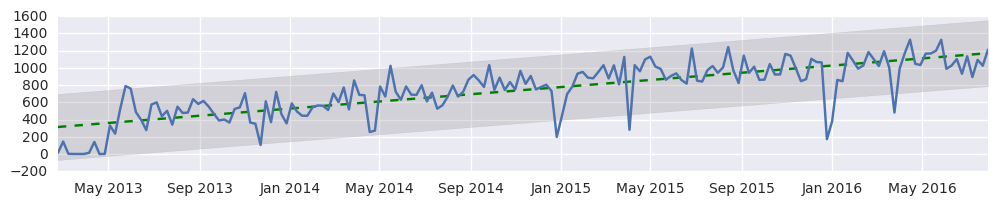

In [2]:
ts = pd.read_csv('outlier.csv').set_index('Date').asfreq('W-FRI', method='pad')
outlier.plotts(ts.Exit, interval=True);

Plotts draws a time series showing a trend line (linear regression) with an optional 2 standard deviations interval either side of the trend. The interval is a crude way to visualise outliers by looking for observations outside of the grey band. The further out the observation is more likely is is an outlier. 

In this data there are 7 places the timeseries is outside the interval but only 4 of these are significantly outside.

# Automatically finding outliers

There are [three common ways](http://colingorrie.github.io/outlier-detection.html) to find outliers:
* **ZScore**: Any observation with a [ZScore](https://en.wikipedia.org/wiki/Standard_score) greater than or less than N standard deviations. When N =2 this is the same as the interval used in plotts. The larger the N the bigger the outlier must be for detection. While ZScore is commonly used it is not a [robust measure](https://en.wikipedia.org/wiki/Robust_measures_of_scale) and is affected by outliers making it a poor choice.
* **MAD**: Any observation with a Robust ZScore greater than or less than N standard deviations. While similar to ZScore it is calculated from the median and [MAD](https://en.wikipedia.org/wiki/Median_absolute_deviation) which makes it a robust measure that performs well for outlier detection. 
* **IQR**: Any observation 1.5 x [IQR](https://en.wikipedia.org/wiki/Interquartile_range) above/below the 25%/75% quartile. This approach is used in a [box plot](https://en.wikipedia.org/wiki/Box_plot) to show outliers. This is a robust measure and is simple to use as there isn't a tuning parameter.

In all cases it is advisable to first remove any trend or seasonal component from the time series. 

plotts can draw the timeseries showing outliers (as read stars) based on one of these three methods, with or without detrending.

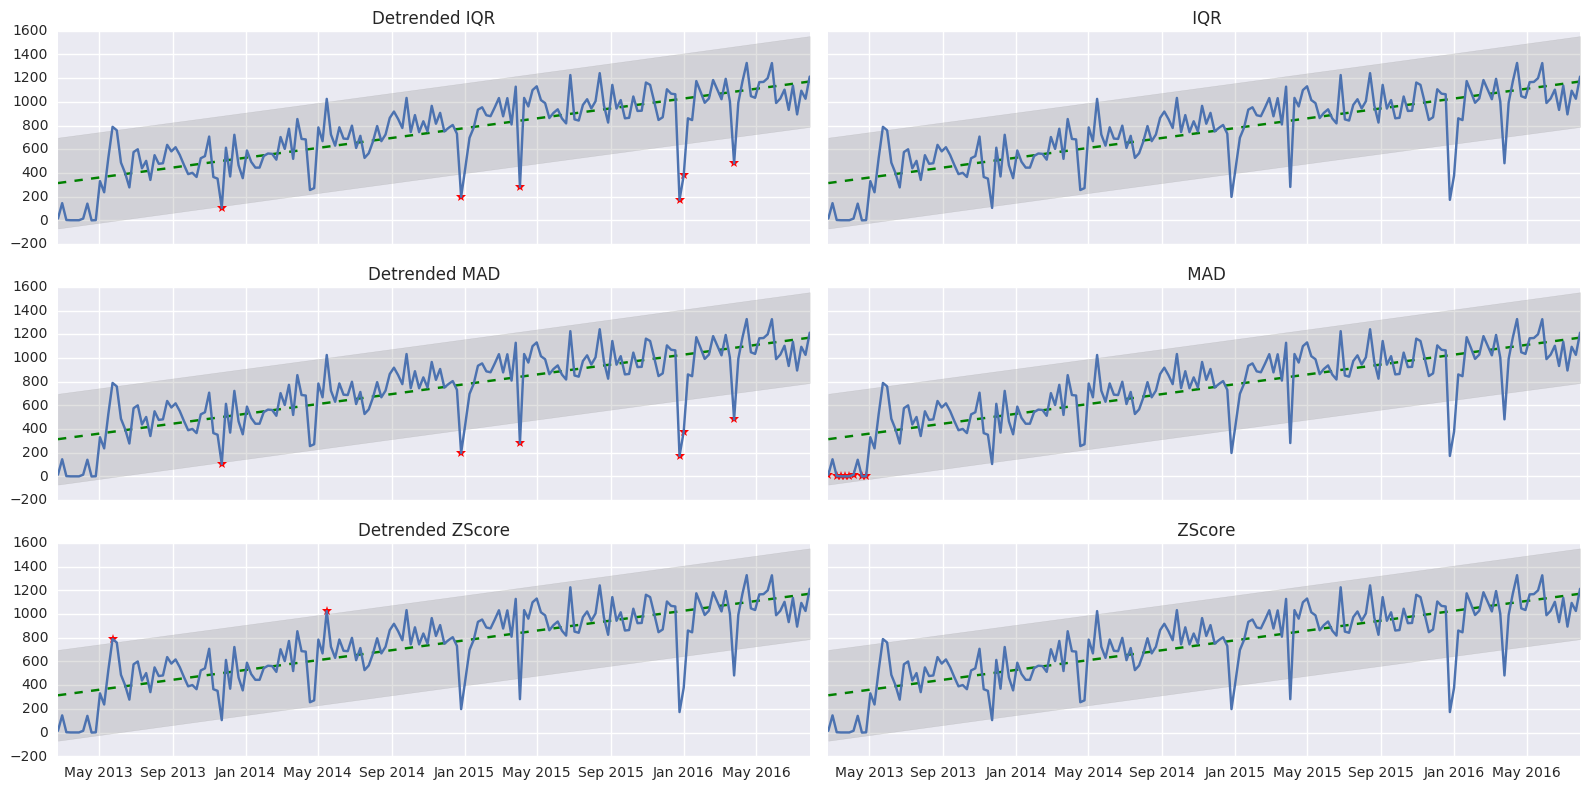

In [3]:
fig, grid = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(16, 8))
for find, axes in zip(["IQR", "MAD", "ZScore"], grid):
    for detrend, ax in zip([True, False], axes):
        outlier.plotts(ts.Exit, ax=ax, interval=True, outliers=True, N=2, find=find, detrend=detrend)
        ax.set_title(("Detrended " if detrend else " ") + find)
        
plt.tight_layout()

We observe that:
* Detrending is essential when a timeseries has a trend like this one does.
* IQR works well on this data and is simple to use.
* MAD works well and has more flexibility than IQR though the tuning of N if desired.
* ZScore is less ffective on this data.

Outliers can be selected from a timeseries using simple pandas slicing and the isoutlier function.

In [4]:
ts[outlier.isoutlier(ts.Exit, find='IQR')]

,Entry,Exit
Date,,
2013-11-22,99,105
2014-12-26,130,198
2015-04-03,169,282
2015-12-25,80,173
2016-01-01,188,379
2016-03-25,241,482


Outliers can be replaced with NaN, or interpolated from neighboring data, using the replace function. Replacing outliers with NaN is useful as it indicates there is a data problem and this approach works with other pandas tools. For example, a plot of a timeseries with the outliers replaced by NaN has breaks in the timesers indicating there is something going at those points.

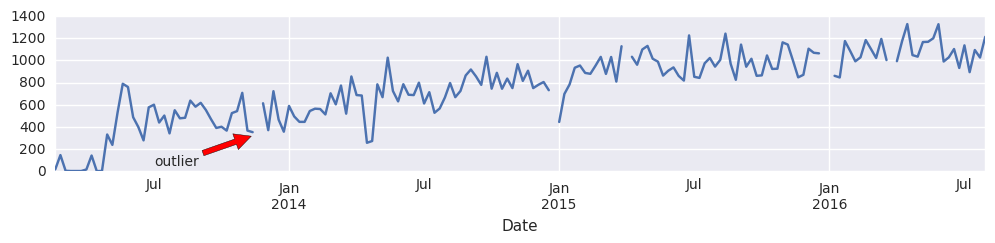

In [5]:
(outlier.replace(ts.Exit, find="IQR").
 plot().
 annotate("outlier", xy=('2013-11-10', 320), xytext=('2013-7-1', 50), 
          arrowprops=dict(facecolor='red', shrink=0.025)));

Outlier replace can use linear interpolation to replace the outliers as we've done below. While the timeseries is far from smooth, it is now much eaiser easier to visualise.

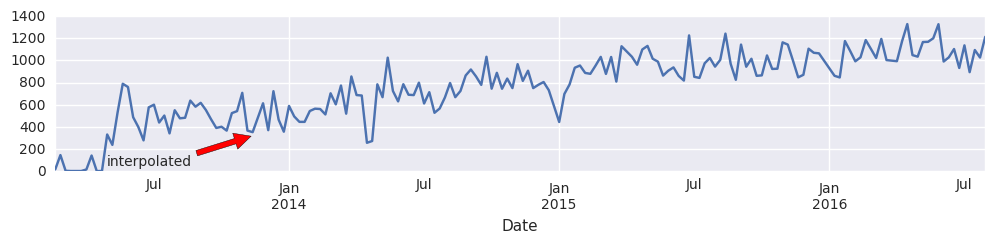

In [6]:
(outlier.replace(ts.Exit, find="IQR", how='Linear').plot().
 annotate("interpolated", xy=('2013-11-10', 320), xytext=('2013-5-1', 50), 
          arrowprops=dict(facecolor='red', shrink=0.025)));

In [7]:
# Exercice all paths
for method in ["MAD", "ZScore", "IQR"]:
    for detrend in [True, False]:
        for order in [1,2]:
            c1 = outlier.isoutlier(ts, N=2, find=method, detrend=detrend, order=order).sum().Exit
            c2 = outlier.isoutlier(ts.Exit, N=2, find=method, detrend=detrend, order=order).sum()
            print("{:>30s} {:}".format(("Quadratic " if order ==2 else "")+("Detrended " if detrend else " ")+method, c1))
            assert c1 == c2, "Series and DataFame have different results {} and {}".format(c1, c2)

                 Detrended MAD 6
       Quadratic Detrended MAD 10
                           MAD 8
                Quadratic  MAD 8
              Detrended ZScore 2
    Quadratic Detrended ZScore 2
                        ZScore 0
             Quadratic  ZScore 0
                 Detrended IQR 6
       Quadratic Detrended IQR 11
                           IQR 0
                Quadratic  IQR 0
